# Preamble

In [3]:
dir_home = '../'
dir_ceph = dir_home+'ceph/luminous-basin/'
dir_events = dir_home+'data/energy_res_data/'
dir_production = dir_ceph+'data/production/'
dir_fig = dir_home+'figures/'

import sys

from my_units import *
from functions_model import * 
from functions_load import *
from functions_yellin import *

# Energy Resolution

## Load energy resolution data

In [4]:
list_files = listdir(dir_events); 
list_files = [file for file in list_files if file[0:2]=='nu'] #select only files starting with 'nu'
list_files

['nu20012004002B06_cl_sunpos.csv',
 'nu20001002001B06_cl_sunpos.csv',
 'nu20001002001A06_cl_sunpos.csv',
 'nu20012004002A06_cl_sunpos.csv',
 'nu20012002001B06_cl_sunpos.csv',
 'nu20012002001A06_cl_sunpos.csv',
 'nu20012003001A06_cl_sunpos.csv',
 'nu20012003001B06_cl_sunpos.csv',
 'nu20012001001A06_cl_sunpos.csv']

In [5]:
list_tables = []
list_X = []
list_Y = []
list_E = []
list_t = []
list_t_min = []
list_t_max = []

for file in list_files:
    table = pd.read_csv(dir_events+file)
    X = np.asarray(table[' Sun X (arcsec)'])
    Y = np.asarray(table[' Sun Y (arcsec)'])
    E = np.asarray(table[' Energy (keV)'])
    t = np.asarray(table['# Time (s)'])
    
    list_tables.append(table)
    list_X.append(X); list_Y.append(Y); list_E.append(E); list_t.append(t)
    list_t_min.append(list_t_min); list_t_max.append(list_t_max); 
    
all_X = np.asarray([item for X in list_X for item in X])
all_Y = np.asarray([item for Y in list_Y for item in Y])
all_E = np.asarray([item for E in list_E for item in E])
all_t = np.asarray([item for t in list_t for item in t])
    
[len(table) for table in list_tables]

[26208, 19396, 94976, 68130, 3099, 27867, 55211, 21417, 3881]

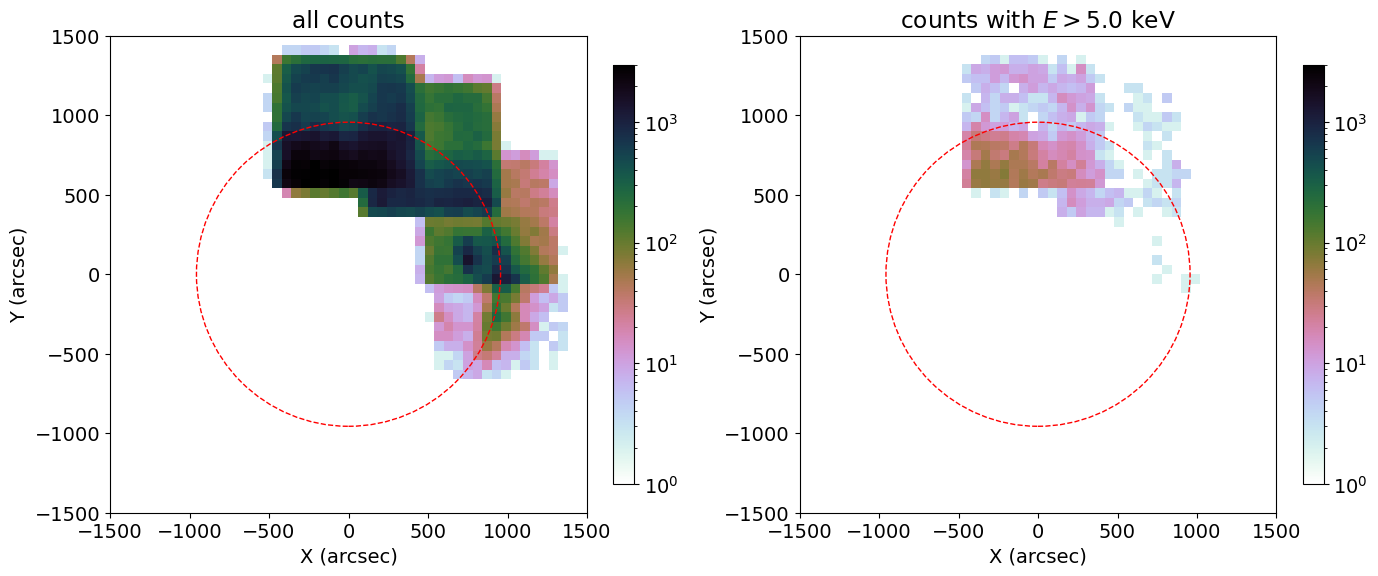

In [9]:
lim_XY = 1500
threshold = 5.0; #energy threshold of panel threshold
vmin = 1
vmax = 3e3
theta_sun = np.arcsin(RSolar/AU) # RSolar/AU

fig, ax = plt.subplots(1,2,figsize=(14,8))
h0 = ax[0].hist2d(all_X,all_Y,bins=[50,50],range=[[-lim_XY,lim_XY],[-lim_XY,lim_XY]],cmap='cubehelix_r',norm=mp.colors.LogNorm(vmin=vmin,vmax=vmax));
fig.colorbar(h0[3],ax=ax[0],fraction=0.04)
ax[0].set_xlabel('X (arcsec)'); ax[0].set_ylabel('Y (arcsec)');
ax[0].set_title('all counts')
h1 = ax[1].hist2d(all_X[all_E>threshold],all_Y[all_E>threshold],bins=[50,50],range=[[-lim_XY,lim_XY],[-lim_XY,lim_XY]],cmap='cubehelix_r',norm=mp.colors.LogNorm(vmin=vmin,vmax=vmax));
fig.colorbar(h1[3],ax=ax[1],fraction=0.04)
ax[1].set_xlabel('X (arcsec)'); ax[1].set_ylabel('Y (arcsec)');
ax[1].set_title('counts with $E > $'+str(threshold)+' keV')
ax[0].set_aspect(1); ax[1].set_aspect(1);
circle1 = plt.Circle((0, 0), theta_sun/arcsec, color='red', ls='dashed', fill=False); circle2 = plt.Circle((0, 0), theta_sun/arcsec, color='red', ls='dashed', fill=False)
ax[0].add_artist(circle1); ax[1].add_artist(circle2);
fig.tight_layout()

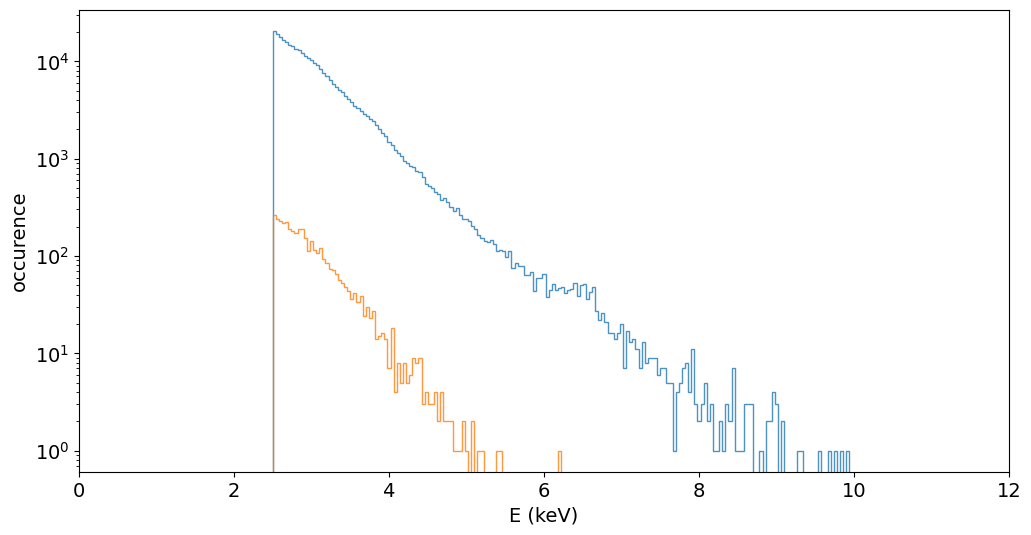

In [10]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
i_tab = 8
[hist_E,E_edges,image] = ax.hist(all_E,bins=np.arange(0.02,12.0,0.04),log=True,histtype='step',alpha=0.8);
ax.hist(list_E[i_tab],bins=np.arange(0.02,12.0,0.04),log=True,histtype='step',alpha=0.8);
ax.set_xlim(0,12); ax.set_xlabel('E (keV)'); ax.set_ylabel('occurence');

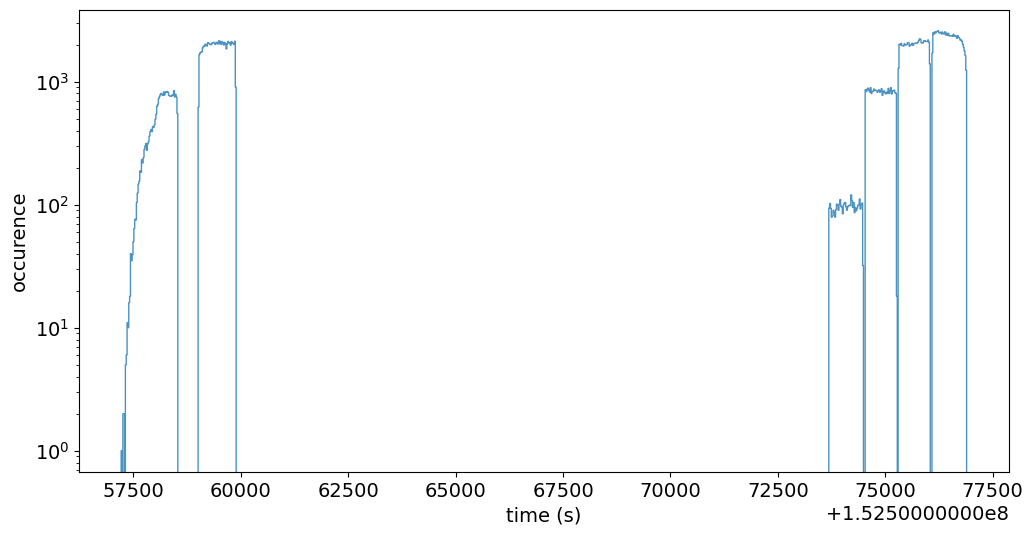

In [11]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.hist(all_t,bins=1000,log=True,histtype='step',alpha=0.8);
#ax.set_xlim(0,12); 
ax.set_xlabel('time (s)'); ax.set_ylabel('occurence');

## Energy resolution

In [16]:
from scipy.optimize import curve_fit

def fit_fun(E, count_cont, E_min, E_line, sigma_E, count_line):
    """fitting function of Boltzmann-suppressed continuum emission plus a Gaussian line"""
    return count_cont * np.exp(-(E/E_min-1)) + count_line * np.exp(- (E-E_line)**2/(2*sigma_E**2))

E_fit_min = 5.6; E_fit_max = 7.2;
indices_fit = [E_fit_min<E<E_fit_max for E in E_edges] # fit from 4 keV to 7 keV
p0 = [5e4, 0.7, 6.4, 0.4, 0]
[p_fit,p_cov] = curve_fit(fit_fun,xdata=E_edges[indices_fit],ydata=hist_E[indices_fit[:-1]],p0=p0,sigma=np.sqrt(hist_E[indices_fit[:-1]]))

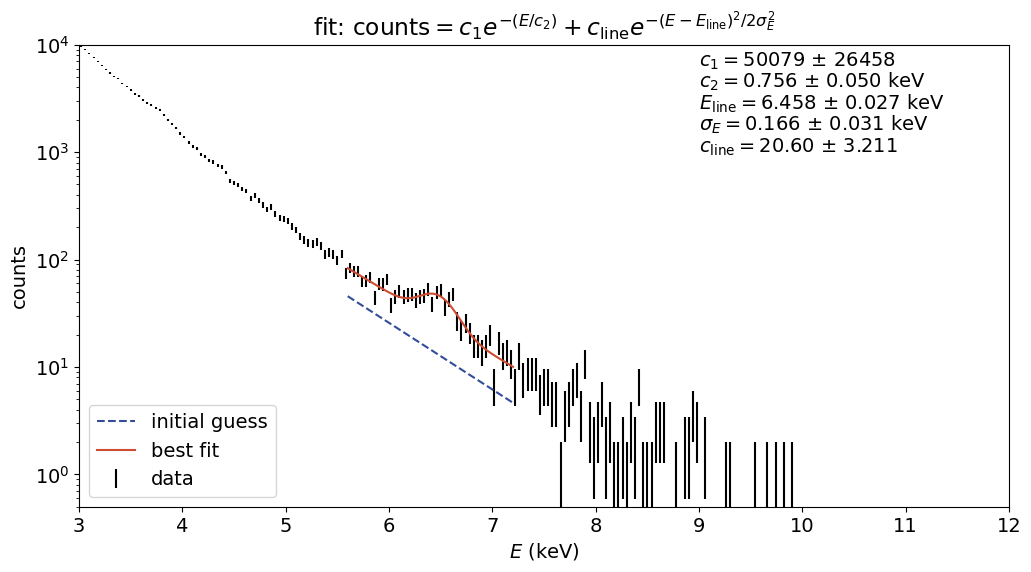

In [22]:
vec_E = np.linspace(E_fit_min,E_fit_max,200)
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(E_edges[:-1],hist_E,np.sqrt(hist_E),fmt='none', label='data',color=(0,0,0))
ax.plot(vec_E,fit_fun(vec_E, p0[0],p0[1],p0[2],p0[3],p0[4]), label='initial guess', color=(0.2,0.3,0.6),ls='dashed')
ax.plot(vec_E,fit_fun(vec_E, p_fit[0],p_fit[1],p_fit[2],p_fit[3],p_fit[4]), label='best fit', color=(0.8,0.3,0.2))
ax.set_yscale('log'); ax.set_ylim(0.5,1e4); ax.set_xlim(3,12);
ax.set_title(r'fit: $\mathrm{counts} = c_1 e^{-(E/c_2)} + c_\mathrm{line} e^{-(E-E_\mathrm{line})^2/2\sigma_E^2}$');
ax.text(9,10**3.8,'$c_1 = $'+str(p_fit[0])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[0,0]))[0:5]);
ax.text(9,10**3.6,'$c_2 = $'+str(p_fit[1])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[1,1]))[0:5]+' keV');
ax.text(9,10**3.4,'$E_\mathrm{line} = $'+str(p_fit[2])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[2,2]))[0:5]+' keV');
ax.text(9,10**3.2,'$\sigma_E = $'+str(p_fit[3])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[3,3]))[0:5]+' keV');
ax.text(9,10**3.0,'$c_\mathrm{line} = $'+str(p_fit[4])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[4,4]))[0:5]);
ax.set_xlabel('$E$ (keV)'); ax.set_ylabel('counts')
ax.legend(loc='lower left');

In [23]:
fig.savefig(dir_fig+'energy_res.pdf',bbox_inches='tight',pad_inches=0.02);